Very messy implementation of https://arxiv.org/pdf/2410.10103

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import diffrax
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

from src.generator import coupled_rossler
from src.koopman import random_fourier_features, dynamic_mode_decomposition, compute_causal_loss

## Generate dynamics 
In particular, trying to replicate Fig 1b.
Since the IC is not defned in the paper, tried to approximate i.e., eye-ball from the subfigure

#### Specify parameters, ICs, timestepping

In [3]:
# Time span
t0, t1 = 0.0, 10.0
dt = 0.01
steps = int((t1 - t0) / dt)

# Parameters
phi1, phi2 = 1.0, 1.0  # Frequencies
a, b, d = 0.2, 0.2, 5.7  # Rössler parameters

# Initial condition (eye-ball from the paper)
initial_state = jnp.array([1.0, -2.0, 0.0, -1.0, 1.0, 0.0])

# Coupling coefficients 
# (causal direction: Omega 2 --> Omega 1; but NOT Omega 1 --> Omega 2)
c2 = 0

### Integrate forward

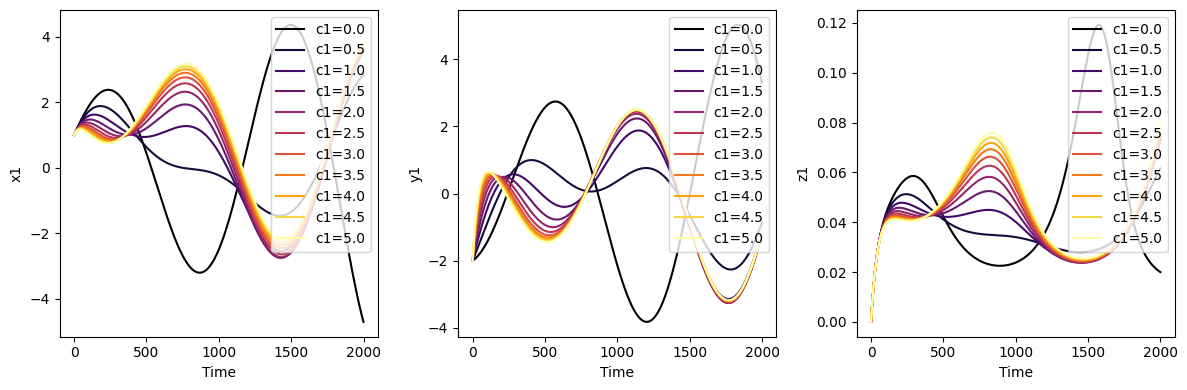

In [4]:
# Integration
solver = diffrax.Dopri5()  # Runge-Kutta solver

# Create figure
f, ax = plt.subplots(1, 3, figsize=(12, 4))

# Generate color map
c1_values = jnp.linspace(0, 5, 11)  # Coupling strength values
colors = cm.inferno(jnp.linspace(0, 1, len(c1_values)))  # Inferno colormap

for c1, color in zip(c1_values, colors):
    params = (phi1, phi2, a, b, d, c1, c2)

    # Solve the system
    solution = diffrax.diffeqsolve(
        diffrax.ODETerm(coupled_rossler),
        solver=solver,
        t0=t0,
        t1=t1,
        dt0=dt,
        y0=initial_state,
        args=params,
        saveat=diffrax.SaveAt(ts=jnp.linspace(t0, t1, 2000)),
        max_steps=100000
    )

    # Extract results (divided into omega_1, omega_2)
    omega_1, omega_2 = solution.ys.T[:3], solution.ys.T[3:]

    # Plot the results
    ax[0].plot(omega_1[0], label=f"c1={c1:.1f}", color=color)
    ax[1].plot(omega_1[1], label=f"c1={c1:.1f}", color=color)
    ax[2].plot(omega_1[2], label=f"c1={c1:.1f}", color=color)

# Add labels and legends
for i, var in enumerate(["x1", "y1", "z1"]):
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(var)
    ax[i].legend(loc="upper right")

plt.tight_layout()
plt.show()

## Causal Koopman

First, we generate data similar to that in the paper

In [5]:
# Integration
t0, t1 = 0.0, 20.0
dt = 0.01
steps = int((t1 - t0) / dt)
c1, c2 = 0.5, 0
params = (phi1, phi2, a, b, d, c1, c2)

# Solve the system
solution = diffrax.diffeqsolve(
    diffrax.ODETerm(coupled_rossler),
    solver=solver,
    t0=t0,
    t1=t1,
    dt0=dt,
    y0=initial_state,
    args=params,
    saveat=diffrax.SaveAt(ts=jnp.linspace(t0, t1, 2000)),
    max_steps=100000
)

# Extract results (divided into omega_1, omega_2)
omega = solution.ys.T
omega_1, omega_2 = omega[:3], omega[3:]

First we building data pair (Equations 4 and 5). Then we separate into cause and effect.

In [6]:
t = 1 # Assume shift of t=1 for now

# Also, separating into cause and effect 
omega_CE = omega[:, :-t]
omega_CE_t = omega[:, t:]

omega_C = omega_2[:, :-t]
omega_C_t = omega_2[:, t:]

omega_E = omega_1[:, :-t]
omega_E_t = omega_1[:, t:]



Second we compute the transform (Equations 6 and 7)

In [7]:
# By default, M = 500
psi_C = random_fourier_features(omega_C)
psi_C_t = random_fourier_features(omega_C_t)

psi_E = random_fourier_features(omega_E)
psi_E_t = random_fourier_features(omega_E_t)

psi_CE = random_fourier_features(jnp.concatenate([omega_C, omega_E], axis=0))
psi_CE_t = random_fourier_features(jnp.concatenate([omega_C_t, omega_E_t], axis=0))

psi_C.shape, psi_C_t.shape, psi_E.shape, psi_E_t.shape # (M, D)


((500, 1999), (500, 1999), (500, 1999), (500, 1999))

Third we derive the corresponding Koopman operator (Equations 8 and 9)

In [8]:
# Example of deriving the Koopman operator given shifts
K_C = dynamic_mode_decomposition(psi_C, psi_C_t)
K_E = dynamic_mode_decomposition(psi_E, psi_E_t)
K_CE = dynamic_mode_decomposition(psi_CE, psi_CE_t)

K_C.shape, K_E.shape, K_CE.shape


((500, 500), (500, 500), (500, 500))

We can compute the K_marginal and K_joint (Equations 14 and 15)

In [9]:
# K_marginal (Equation 14)
K_marginal = dynamic_mode_decomposition(
    jnp.concatenate([omega_E, psi_E], axis=0), omega_E_t
)

# K_joint (Equation 15), note the addition of psi_C
K_joint = dynamic_mode_decomposition(
    jnp.concatenate([omega_E, psi_CE], axis=0), omega_CE_t
)

K_marginal.shape, K_joint.shape


((3, 503), (6, 503))

We can then derive the w_marginal and w_joint (Equations 16 and 17)

In [10]:
omega_marginal = K_marginal @ jnp.concatenate([omega_E, psi_E], axis=0) # Equation 16
omega_joint = K_joint @ jnp.concatenate([omega_E, psi_CE], axis=0) # Equation 17

omega_marginal.shape, omega_joint.shape # (N_effect, D-t) or (N, D-t)


((3, 1999), (6, 1999))

We can then compute the loss (Equations 18 and 19)

In [13]:
marginal_err = jnp.square(omega_marginal - omega_E_t).mean() # Marginal error
joint_err = jnp.square(omega_joint[3:] - omega_E_t).mean() # Joint error

model_err = marginal_err - joint_err # Equation 19
model_err


Array(-0.8024213, dtype=float32)

## Causal dependence with increasing shifts

We evaluate the temporal dependence. We notice, as expected, that the causal dependence is getting weaker as the shift is increased.
All the above codes are abstracted for readability in the subsequent analysis.

100%|████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:48<00:00,  1.19it/s]


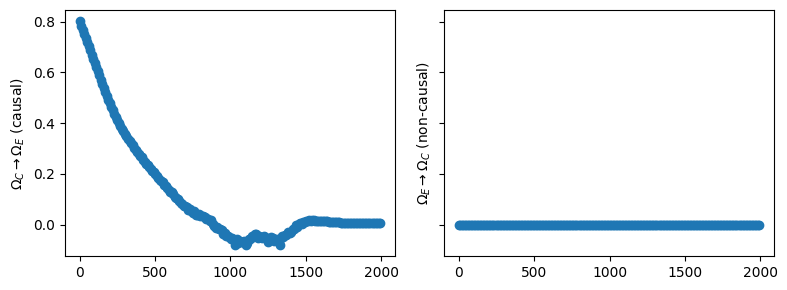

In [15]:
# Causal and non-causal direction (estimated by the causal loss)
time_shifts = jnp.arange(1, 2000, 10)
losses = {'causal': [], 'non_causal': []}

for t in tqdm(time_shifts):
    causal_loss, non_causal_loss, _, _, _, _ = compute_causal_loss(
        cause=omega_2, 
        effect=omega_1,
        t=t
    )
    
    losses['causal'].append(causal_loss)
    losses['non_causal'].append(non_causal_loss)

# Plot
f, ax = plt.subplots(1,2, figsize=(8,3), sharey=True)
ax[0].scatter(time_shifts, losses['causal'])
ax[0].set_ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')
ax[1].scatter(time_shifts, losses['non_causal'])
ax[1].set_ylabel(r'$\Omega_E \rightarrow \Omega_C$ (non-causal)')

plt.tight_layout()
plt.show;

In [16]:
# Inference in the causal and non-causal direction (assume shift of t=1)
_, _, omega_marginal_causal, omega_joint_causal, omega_marginal_non_causal, omega_joint_non_causal = compute_causal_loss(
        cause=omega_2, 
        effect=omega_1,
        t=1
)


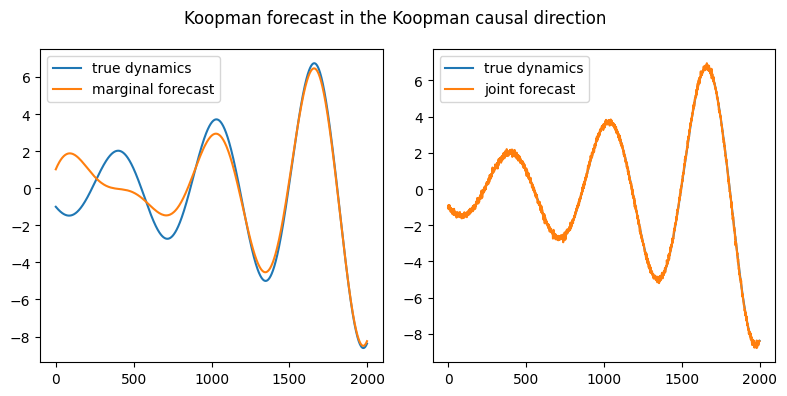

In [17]:
# Plot (marginal and joint) -- causal
f, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(omega_C[0], label='true dynamics')
ax[0].plot(omega_marginal_causal[0], label='marginal forecast')
ax[0].legend()

ax[1].plot(omega_C[0], label='true dynamics')
ax[1].plot(omega_joint_causal[0], label='joint forecast')
ax[1].legend()

f.suptitle('Koopman forecast in the Koopman causal direction')
plt.tight_layout()
plt.show();


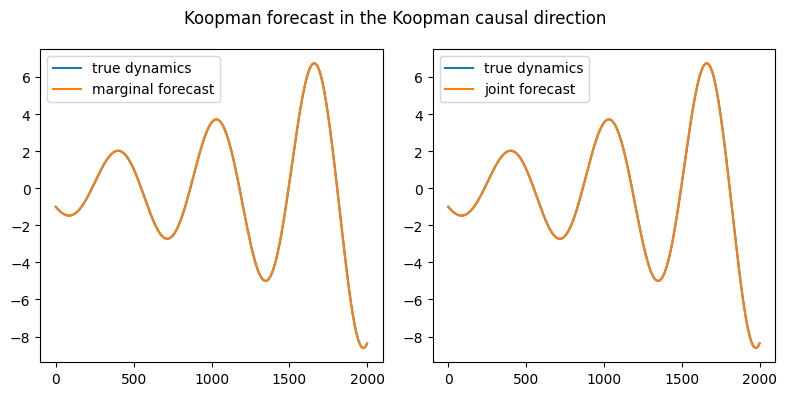

In [18]:
# # Plot (marginal and joint) -- non-causal
f, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(omega_C[0], label='true dynamics')
ax[0].plot(omega_marginal_non_causal[0], label='marginal forecast')
ax[0].legend()

ax[1].plot(omega_C[0], label='true dynamics')
ax[1].plot(omega_joint_non_causal[0], label='joint forecast')
ax[1].legend()

f.suptitle('Koopman forecast in the Koopman causal direction')
plt.tight_layout()
plt.show();
